In [1]:
# Preliminaries not useful to show in talk. Execute before slideshow.
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

real_range = widgets.FloatRangeSlider(
    value=[-2, 1],
    min=-2,
    max=1.0,
    step=0.01,
    description='Real range:',
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    continuous_update=False,
    layout=Layout(width='80%', height='30px'),
)
imag_range = widgets.FloatRangeSlider(
    value=[-1, 1],
    min=-1,
    max=1,
    step=0.01,
    description='Imag range:',
    orientation='horizontal',
    readout=True,
    continuous_update=False,
    readout_format='.2f',
    layout=Layout(width='80%', height='30px'),
)


import matplotlib.pyplot as plt
%matplotlib inline


Using GPUs at Warwick
========================

D. Quigley, Computational Techniques 2020

---

<table>
<tr>
    <td>
        <img src="https://images-na.ssl-images-amazon.com/images/I/71JLm2psPeL._SL1500_.jpg" width=300 height=300>
    </td>
    <td>
        <img src="https://images-na.ssl-images-amazon.com/images/I/61G6uH2aUxL._SL1200_.jpg" width=300 height=300>
    </td>
</tr>
    
<tr>
    <td width="500px">
        <center><h3>Intel 8-core central processing unit (CPU)</h3></center>
    </td>
    <td width="500px">
       <center><h3> Nvidia GeForce 1080 Graphics Processing Unit (GPU) with 2560 "CUDA cores"</h3></center>
    </td>
    
</tr>   
</table>

## GPU Pros?

* #### Parallel execution of thousands of threads vs a few dozen (maximum) on a CPU
* #### Huge energy efficiency in comparison to the same performance on a traditional CPU cluster

## GPU Cons?

* ####  Typically no more than 32GB of RAM per device, compared to 2-4GB per CPU core in traditional HPC clusters
* ####  Clock rate of around 1-2 GHz vs 3-5 GHz in CPUs, and less work done per clock 'tick'
* ####  Bandwidth between device memory and the compute units is fast, but not thousands of times faster than CPUs
* ####  Threads are grouped into *warps* which all execute instructions in lockstep
* ####  Code must be (re)written to explicitly make use of the GPU capabilities
* ####  Only a (growing) subset of your favourite langauge features can execute on a GPU
* ####  Not all computational tasks are suitable for GPU acceleration

## Requirements for GPU computing

* #### [A CUDA-capable Nvidia GPU](https://www.geforce.com/hardware/technology/cuda/supported-gpus)
* #### [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit)
* #### Cheap (£60) desktop cards fine for development and testing, but performance very limited
* #### High-end gaming cards (£600-£1,000) can be very powerful for CUDA but lack error correction/detection and features needed for remote monitoring and management in server environments. Poor double precision performance
* #### Tesla series aimed squarely at high performance computing market


| GPU card              |  Cores  | Single Precision TFLOPS | Double Precision TFLOPS   | GPU Memory Bandwidth GB/s  |
| ----------------------|:--------|:------------------------|:-------------------------:|---------------------------:|
| Tesla K20 (2012)        | 2496 | 3.52 | 1.18 |  208 |
| Tesla K40 ([Chiron](https://warwick.ac.uk/research/rtp/sc/hpc)) (2014)         | 2880 | 4.23 | 1.43 |  235 |
| Telsa K80 ([Tinis](https://warwick.ac.uk/research/rtp/sc/hpc)) (2015)   |  4992   | 5.59 | 1.87                      | 480                        |
| Tesla P100 ([Orac](https://warwick.ac.uk/research/rtp/sc/hpc)) (2017)   |  3584   | 8.07 | 4.36                       | 732                        |
| RTX 6000 ([Avon](https://warwick.ac.uk/research/rtp/sc/hpc)) (2020)     |  4608   | 16.03 | 0.51 | 672  |
| A100 (2020) |  6912   | 19.5 | 9.7 | 1,600  |
| GeForce 3080 (Gaming)|  10496   | 25.1 | 0.93                     | 936                        |

(Quoting [Wikipedia](https://en.wikipedia.org/wiki/Nvidia_Tesla) - TFLOPS shown are without Nvidia Boost)

## Programming model

* ####  CUDA is the (proprietary) programming model for exploiting Nvidia GPUs
* ####  Others exist (e.g. OpenCL) but arguably CUDA has become the de-facto standard and is much easier to learn
* ####  CUDA extends the C programming language with GPU features. CUDA Fortran also exists (and is now free via Nvidia HPC SDK)
* ####  Various third party tools for other languages - we will focus on [Numba](https://numba.pydata.org/) for Python as it appears closer in spirit to CUDA with compiled languages and so concepts are transferable

## CUDA and the [Scientific Computing Research Technology Platform (SCRTP)](https://warwick.ac.uk/research/rtp/sc)

* #### Managed desktop supports CUDA toolkit 10.1 for machines with GPU cards which support it
* #### CUDA 11 support on its way. Can be installed locally by users now on compatible machines
* #### Check support using `nvidia-smi` in the terminal
* #### Most desktop machines are supported. Some spare GeForce 1030 cards are available for machines which can accomodate them
* #### 16 GPU nodes each with 3x on Nvidia RTX 6000 hardware in Avon, and 1 OpenPower testbed with 4x Nvidia P100 cards. Available to all users via batch queues

# Example 1 : Preliminaries

### Sanity check of Python environment

## Some terminology:

*  **Host**        : The traditional computer in which our code is running on a CPU with access to host RAM

* **CUDA Device** : The GPU card consisting of its own RAM and computing cores (lots of them) 

In [2]:
import platform          # So we can figure out where we're running
from numba import cuda   # Import python interface to CUDA

# Report where we're running
print("========================================================")
print("This notebook is running on ", platform.node())
print("========================================================")

# Test if CUDA is available. If so report on the devices present 
if cuda.is_available():  
    
    # List of CUDA capable devices in this system
    for device in cuda.list_devices():       
        print("Device ID : ", device.id, " : ", device.name.decode())         
    
else:
    print("There doesn't appear to be a CUDA capable device in this system")

This notebook is running on  brigitte.csc.warwick.ac.uk
Device ID :  0  :  Tesla K20c
Device ID :  1  :  GeForce GT 1030


* #### Select the the most appropriate device and query its [compute capability](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities)

* #### [Numba requires a compute capability of 2.0 or higher](https://numba.pydata.org/numba-doc/dev/cuda/overview.html)

In [3]:
my_instance = cuda.select_device(0) # Create a device instance to work with based on device 0 

# The compute capability is stored as a tuple (major, minor) so we're good to go if...
if my_instance.compute_capability[0] >= 2 and my_instance.compute_capability[1] >= 0 :
    print("The selected device (",my_instance.name.decode(),") has a sufficient compute capability")
else:
    print("The selected device does not have a sufficient compute capability")

The selected device ( Tesla K20c ) has a sufficient compute capability


Normally we won't need to call ```cuda.select_device()```. The default context will be the fastest GPU in the machine. 

# Example 2 : Libraries

### e.g. BLAS (Basic Linear Algebra Subprograms)



* #### BLAS is the suite of [Basic Linear Algebra Subprograms](http://www.netlib.org/blas/). 
* #### These come in three levels, for both real and complex data types 

 - **Level 1** : Vector-vector operations 

 - **Level 2** : Matrix-vector operations

 - **Level 3** : Matrix-matrix operations

## cuBLAS

* #### The CUDA toolkit includes [cuBLAS](https://developer.nvidia.com/cublas), a GPU-accelerated BLAS implementation

* #### [pyculib](http://pyculib.readthedocs.io/en/latest/cublas.html) provides a Python interface to this
  e.g. matrix-matrix multiplication example. BLAS routine `dgemm` (double precision, general matrix-matrix multiply) performs 
  $$ C = \alpha AB + \beta C, $$
  where $A$, $B$ and $C$ are matrices and $\alpha$ and $\beta$ are scalars. 

* #### Numpy CPU-based matrix multiplication for comparison

In [4]:
import numpy as np
from timeit import default_timer as timer  # Timer

size = 1000

# Create some square matrices and fill them with random numbers
A = np.random.rand(size,size)
B = np.random.rand(size,size)

# Alpha (we'll leave beta as zero)
alpha = 1.0

# What is the time before we start the operation?
t1 = timer()

# Perform the operation described above using standard numpy
C_np = alpha * np.matmul(A, B) 

# What is the time after we finish the operation in milliseconds?
t2 = timer()

# Print time taken
print("Matrix multiplication using numpy took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using numpy took :  16.597264970187098  milliseconds.


* #### Using Python interface to cuBLAS 

In [5]:
import pyculib.blas as cublas      # Python interface to cuBLAS

# First event before® we call gemm
t1 = timer()

# Do the multiplication
C_cu = cublas.gemm('N', 'N', alpha, A, B)

# Second event after we call gemm
t2 = timer()

# Print time taken
print("Matrix multiplication using cuBLAS took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using cuBLAS took :  223.51373301353306  milliseconds.


## Other libraries

Many other GPU accelerated libraries exist. For example...

* [cuFFT](http://pyculib.readthedocs.io/en/latest/curand.html) : Part of the Nvidia toolkit. Fast Fourier Transform calculation.
* [cuRAND](http://pyculib.readthedocs.io/en/latest/curand.html)      : Part of the Nvidia toolkit. Fast random number generation on GPUs for applications which need large numbers of samples 
* [cuSPARSE](http://pyculib.readthedocs.io/en/latest/cusparse.html)    : Part of the Nvidia toolkit. Sparse linear algebra library
* [Magma](https://icl.cs.utk.edu/magma/) : Dense linear algebra library similar to LaPACK
* [cuDNN](https://developer.nvidia.com/cudnn)       : Nvidia Deep Neural Network Library (used by e.g. [TensorFlow](https://www.tensorflow.org/)) 
* [libgpuarray](http://deeplearning.net/software/libgpuarray/installation.html) : Another tensor manipulation library with [PyGPU](http://deeplearning.net/software/libgpuarray/pyapi/pygpu.html) as the Python interface. Used by [Theano](http://deeplearning.net/software/theano/) 

These are all available via the environment module system on the SCRTP desktops/workstations.

# Example 3 : Kernels

### Writing your own functions which execute on the GPU device

## What is a kernel?

* #### A function which operates on an element of data and is executed by a CUDA thread
* #### We launch enough threads such that the operation is performed on all elements
* #### Threads are mapped onto our data via a grid of thread blocks
* #### Each instance of the function (thread) must be able to identify its location in the grid 
* #### Kernels are launched/invoked by the host, but run on the GPU\*

(* Newer version of CUDA allow kernels to launch kernels, but numba doesn't support this yet)

## Kernel limitations

* #### Can only return data via arguments to the kernel function - no return value
* #### Kernels cannot perform input or output - no printing or reading/writing files
* #### Exception handling inside kernels is limited (no ```try```/```catch```)
* #### Only a subset of the host language (e.g. Python or C) is supported
* #### Threads execute in lockstep within *warps* of 32 threads which map onto *multiprocessors* (groups of CUDA cores, e.g. 8, 32 or 128, 192 etc depending on the architecture version)

The final limitation might seem unimportant, but this means that anything which causes one thread in a warp to wait (e.g. for data to arrive from memory) will cause all threads to wait. Similary branches, (if statements) are problematic. Each thread must execute both branches and then decide which result to keep. This may subvert traditional expectations of how to optimise code.

## Thread blocks/grids

* #### Threads within a block can make use of some *shared device memory* 
* #### All threads can read/write to global device memory. 
* #### There are hardware limitations on the number of threads per block
* #### The grid can be 1D, 2D or 3D

See https://numba.pydata.org/numba-doc/dev/cuda/cudapysupported.html for supported features. 

## Mandelbrot set

* #### Example based on generation of the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set). Borrowing very heavily here from an [example workbook on GitHub](https://github.com/harrism/numba_examples/blob/master/mandelbrot_numba.ipynb)

* #### Coordinates $x$, $y$ are part of the Mandelbrot set if the iterative map
  $$ z_{i+1} = z_{i}^{2} + c $$
  #### does not diverge when the complex numbers $z_{0} = 0$ and $ c = x + iy$. 

* #### Represent graphically as number of iterations taken to reach $ |z_{i}| >= 4 $
* #### Colour map over the Argand plane

* #### Function to calculate number of iterations

In [6]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

* #### Numpy code running on the CPU to generate the image

In [7]:
# Array to hold the output image - i.e. number of iterations 
# as an unsigned 8 bit integer
image = np.zeros((800, 1600), dtype = np.uint8)

# Range over which we want to explore membership of the set
rmin = -2.0 ; rmax = 1.0
imin = -1.0 ; imax = 1.0

# Maximum number of iterations before deciding "does not diverge"
maxits = 20

t1 = timer() # Start timer

pixel_size_x = (rmax - rmin) / image.shape[1]
pixel_size_y = (imax - imin) / image.shape[0]

# This is probably the most non-pythonic way to do this...
for index, pixel in np.ndenumerate(image):
    real = rmin + index[1] * pixel_size_x
    imag = imin + index[0] * pixel_size_y
        
    image[index[0],index[1]] = mandel(real, imag, maxits)
        
t2 = timer()

Mandelbot created on CPU in :  4976.727008004673  milliseconds.


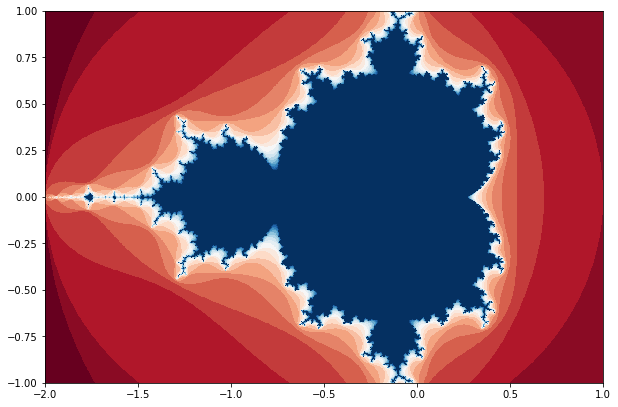

In [8]:
# Print time taken
print("Mandelbot created on CPU in : ",1000*(t2-t1)," milliseconds.")

# Display the image
fig = plt.figure(figsize = [10, 10])
plt.imshow(image,cmap='RdBu', extent=[rmin, rmax, imin, imax]);

* #### For the GPU version we need `mandel` as a function which runs on the device

In [9]:
# Create the device function mandel_gpu from the function "mandel" above
mandel_gpu = cuda.jit(device=True)(mandel)

* #### We also need a kernel launched by the host to run on the device

In [10]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  """
    GPU kernel invoked on every pixel in an image.
  """
  
  # Get the dimensions of the grid from the image device array
  dimx = image.shape[1]
  dimy = image.shape[0]

  # Work out spacing between elements 
  pixel_size_x = (max_x - min_x) / dimx
  pixel_size_y = (max_y - min_y) / dimy

  # What elements of the image should this thread operate on?
  tx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
  ty = cuda.threadIdx.y + cuda.blockDim.y * cuda.blockIdx.y

  # Coordinates in the complex plane
  real = min_x + tx * pixel_size_x
  imag = min_y + ty * pixel_size_y 
    
  # Count number of interations needed to diverge and store in the image
  if ty < dimy and tx < dimx:
      image[ty, tx] = mandel_gpu(real, imag, iters)

* #### The array `image` will be a device array, it exists on the device not the host

* #### The decorator `@cuda.jit` defines this as a kernel
* #### It is compiled to GPU code "just in time" (jit)
* #### The kernel needs to know which part of the image to calculate
  ```python
  cuda.threadIdx.x  # Thread index in current block
  cuda.blockIdx.x   # Block index
  cuda.blockDim.x   # Num Threads in each block
  ```
  ... plus similar in the y direction (and z if in 3D). 
  
* #### Thread coordinates within the overall grid

  ```python
  tx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
  ty = cuda.threadIdx.y + cuda.blockDim.y * cuda.blockIdx.y
  ```

* #### Check that `tx` and `ty` will have something to operate on 
  ```python
     if ty < dimy and tx < dimx:
         image[ty, tx] = mandel_gpu(real, imag, iters)
  ```
* #### Good practice - host code may specify more threads than pixels 

* #### Host code, runs on the CPU and invokes the kernel

In [11]:
# The image size above is chosen to map onto a whole number of threadblocks. 
# IMPORTANT - we normally think of arrays indexed as row, column hence y, x
# The tuples specifiying the thread grid dimensions are indexed as x, y
threads_per_block = (32, 32) 

bx = image.shape[1] // threads_per_block[1] + 1
by = image.shape[0] // threads_per_block[0] + 1

blocks_per_grid = (bx, by)

t1 = timer() # Start timer

# Copy image to a device array which we will populate in our kernel
d_image = cuda.to_device(image)

# Launch the kernel, passing the range of x and y to use 
mandel_kernel[blocks_per_grid, threads_per_block](rmin, rmax, imin, imax, d_image, maxits) 

# Copy the resulting image back to the host
image = d_image.copy_to_host()

t2 = timer()  # Stop timer

print("Mandelbot created on GPU in : ",1000*(t2-t1)," milliseconds.")

Mandelbot created on GPU in :  384.0441440115683  milliseconds.


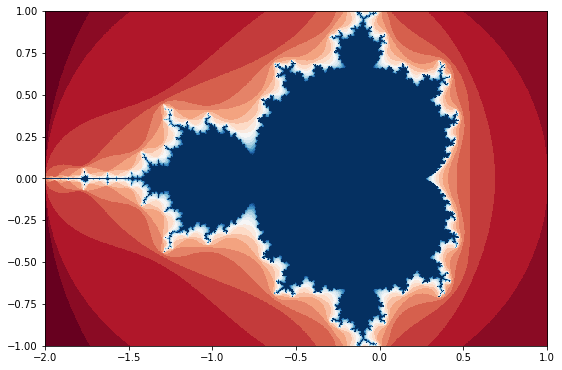

In [12]:
# Display the image
plt.figure(figsize = [9, 9])
plt.imshow(image,cmap='RdBu', extent=[rmin, rmax, imin, imax]);

* #### Function to generate image over a given range

In [13]:
def update_plot(rrange, irange):

    (rmin, rmax) = rrange
    (imin, imax) = irange 
                   
    t1 = timer() # Start timer

    # Launch the kernel, passing the range of x and y to use 
    mandel_kernel[blocks_per_grid, threads_per_block](rmin, rmax, imin, imax, d_image, maxits) 

    # Copy the resulting image back to the host
    image = d_image.copy_to_host()

    t2 = timer()  # Stop timer
    
    print("Mandelbot created on GPU in : ",1000*(t2-t1)," milliseconds.")
    
    # Display the image
    plt.figure(figsize = [12, 12]);
    plt.imshow(image, cmap='RdBu', aspect='auto', extent=[rmin, rmax, imin, imax]);

* #### Explore the real and imaginary range

In [15]:
myplot=interact(update_plot, rrange=real_range, irange=imag_range, continuous_update=True);

interactive(children=(FloatRangeSlider(value=(-1.43, -1.41), continuous_update=False, description='Real range:…

# Summary

* ####  GPUs provide access to thousands of simple compute cores
* ####  GPU accelerated libraries exist, often as drop-in replacements for CPU code
* ####  Writing custom kernels can be fairly simple
* ####  Significant speedups available for some (but by no means all) problems

### Final points

* #### More examples notebooks at [GitHub/WarwickRSE/gpuschool2018](https://github.com/WarwickRSE/gpuschool2018)
* #### New "Avon" HPC cluster coming early 2021 will have many GPU nodes